# Type 2 diabetes model

In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score
import warnings
from matplotlib import pyplot as plt
plt.style.use('ggplot')
warnings.filterwarnings(action='ignore')
import sklearn 
import jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme='oceans16')

### Data Preprocessing

In [60]:
t2d_train_df = pd.read_table("../data/T2D_data/T2D_training_ML_table.txt")
t2d_test_df = pd.read_table("../data/T2D_data/T2D_testing_ML_table.txt")
t2d_train_df.tail()

,snp,type,MCF-7_ChIP-seq_CTCF_ENCSR000AHD_ENCFF001UML_ENCFF001UMN_intersect.bed,MCF-7_ChIP-seq_TAF1_ENCSR000AHF_ENCFF001UNU_ENCFF001UNT_intersect.bed,GM12878_ChIP-seq_CTCF_ENCFF002CDP.bed,K562_ChIP-seq_CTCF_ENCFF002CEL.bed,K562_ChIP-seq_POLR2A_ENCFF002CET.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_CTCF_ENCFF002CEH.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_POLR2A_ENCFF002CEJ.bed,keratinocyte_ChIP-seq_CTCF_ENCFF002CFA.bed,...,Hepatocyte_PPARA_GW7647_2hr.bed,Hepatocyte_PPARA_GW7647_24hr.bed,liver_USF1_ctrl_peaks.narrowPeak,liver_USF1_ASH_peaks.narrowPeak,islet_pooled_H3K4me1_final.bed,islet_CTCF_intersectall.bed,islet_H3K27ac.bed,islet_pooled_H3K27ac.bed,islet_pooled_H3K4me3_peaks.broadPeak,snpcount
2116,Chr1_Group_1072,control,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,65
2117,Chr2_Group_372,control,1,0,0,1,0,1,0,1,...,0,0,0,0,0,1,0,0,0,5
2118,Chr17_Group_188,control,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,8
2119,Chr22_Group_200,control,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,5
2120,Chr6_Group_23,control,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,31


In [61]:
def show_counts(df, pos_col, neg_col):
    # Read in data and compare class balances
    positives = df['type'].value_counts()[pos_col]
    controls = df['type'].value_counts()[neg_col]
    total = len(df)

    print ("Total samples: {} \nPositives: {} \nControls: {}".format(total, positives, controls))

In [62]:
# Read in training data and compare class balances
show_counts(t2d_train_df, 'index', 'control')

Total samples: 2121 
Positives: 303 
Controls: 1818


In [63]:
# Read in testing data and compare class balances
show_counts(t2d_test_df, 'index', 'control')

Total samples: 1064 
Positives: 152 
Controls: 912


In [64]:
# Change labels to 0 or 1 for control or positive
t2d_train_df['type'] = t2d_train_df['type'].apply(lambda x: 0 if x == 'control' else 1)
t2d_test_df['type'] = t2d_test_df['type'].apply(lambda x: 0 if x == 'control' else 1)

# Add sample weights based on prevalence of class
t2d_train_df['weight'] = t2d_train_df['type'].apply(lambda x: 1.5 if x == 1 else 1)

In [65]:
t2d_train_df.head()

,snp,type,MCF-7_ChIP-seq_CTCF_ENCSR000AHD_ENCFF001UML_ENCFF001UMN_intersect.bed,MCF-7_ChIP-seq_TAF1_ENCSR000AHF_ENCFF001UNU_ENCFF001UNT_intersect.bed,GM12878_ChIP-seq_CTCF_ENCFF002CDP.bed,K562_ChIP-seq_CTCF_ENCFF002CEL.bed,K562_ChIP-seq_POLR2A_ENCFF002CET.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_CTCF_ENCFF002CEH.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_POLR2A_ENCFF002CEJ.bed,keratinocyte_ChIP-seq_CTCF_ENCFF002CFA.bed,...,Hepatocyte_PPARA_GW7647_24hr.bed,liver_USF1_ctrl_peaks.narrowPeak,liver_USF1_ASH_peaks.narrowPeak,islet_pooled_H3K4me1_final.bed,islet_CTCF_intersectall.bed,islet_H3K27ac.bed,islet_pooled_H3K27ac.bed,islet_pooled_H3K4me3_peaks.broadPeak,snpcount,weight
0,Chr12_Group_459,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11,1.5
1,Chr6_Group_395,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,1.5
2,Chr5_Group_351,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1.5
3,Chr16_Group_19,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,36,1.5
4,Chr5_Group_55,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1.5


In [66]:
# Drop the snp feature so that only numerical data remains
t2d_train_df = t2d_train_df.drop(['snp'], axis=1)
t2d_test_df = t2d_test_df.drop(['snp'], axis=1)

In [67]:
# Verify value counts are the same to check conversion was performed correctly
show_counts(t2d_train_df, 1, 0)

Total samples: 2121 
Positives: 303 
Controls: 1818


In [68]:
show_counts(t2d_test_df, 1, 0)

Total samples: 1064 
Positives: 152 
Controls: 912


In [69]:
# Drop random samples from control class
# pct_to_drop = 0.5
# t2d_train_df = t2d_train_df.drop(t2d_train_df[t2d_train_df['type'] == 0].sample(frac=pct_to_drop).index)
# print ("Dropped {} % of control class.".format(pct_to_drop))
# show_counts(t2d_train_df, 1, 0)

In [70]:
# Write out data to file so we don't have to repeat preprocessing 
# every time we train a model from a different file
t2d_train_df.to_csv("../data/T2D_data/T2D_train.csv")
t2d_test_df.to_csv("../data/T2D_data/T2D_test.csv")

In [71]:
# Shuffle dataframe
t2d_train_df = t2d_train_df.sample(frac=1)
t2d_test_df = t2d_test_df.sample(frac=1)

In [72]:
# Create training and test sets for model
X_train = t2d_train_df.drop(['type', 'weight'], axis=1)
y_train = t2d_train_df.loc[:, 'type']

X_test = t2d_test_df.drop(['type'], axis=1)
y_test = t2d_test_df.loc[:, 'type']

In [73]:
# If we want to add sample weights
sample_weight = t2d_train_df['weight']

### Logistic Regression 

Sklearn's logistic regression model, with ten fold cross validation. Using the following parameters:
* cv = 10
* penalty = L1 (Same as lasso regression)
* class_weight = balanced (Sets regularization term C to 1/(class frequency) for each sample. Useful for imbalanced datasets. 

In [74]:
log_model = LogisticRegressionCV(solver='liblinear', 
                                 penalty='l1', 
                                 class_weight='balanced',
                                 scoring='roc_auc', 
                                 cv=10,
                                 max_iter=5000)
log_model.fit(X_train, y_train, sample_weight=sample_weight)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=5000,
           multi_class='warn', n_jobs=None, penalty='l1',
           random_state=None, refit=True, scoring='roc_auc',
           solver='liblinear', tol=0.0001, verbose=0)

In [75]:
'''
Predict class using a model that predicts probabilities with a user 
defined threshold for classification
'''
def predict_class(model, Xtest, threshold):
    logits = model.predict_proba(Xtest)
    predictions = [1 if float(sample[1]) > threshold else 0 for sample in logits]
    return predictions


'''
Summarize model performance with precision and recall statistics
'''
def summarize_performance(model, X, y, threshold=0.5, proba=True):
    if proba:
        predictions = predict_class(model, X, threshold)
    else:
        predictions = model.predict(X)
    
    precision = precision_score(y_true=y, y_pred=predictions)
    recall = recall_score(y_true=y, y_pred=predictions)
    accuracy = model.score(X, y)
    print ("Model Performance:\n Precision: {}\n Recall: {}\n Accuracy: {}".format(precision, recall, accuracy))

In [76]:
print("Training Dataset Logistic", end=" ")
summarize_performance(log_model, X_train, y_train, threshold=0.5)

Training Dataset Logistic Model Performance:
 Precision: 0.25627240143369173
 Recall: 0.9438943894389439
 Accuracy: 0.8408489363787864


In [77]:
print("Test Dataset Logistic", end=" ")
summarize_performance(log_model, X_test, y_test, threshold=0.5)

Test Dataset Logistic Model Performance:
 Precision: 0.18584070796460178
 Recall: 0.6907894736842105
 Accuracy: 0.6581832871652817


In [78]:
print (log_model.predict(X_test))

[1 1 0 ... 1 1 0]


In [79]:
def plot_roc_curve(model, Xtest, ytest):
    # calculate the fpr and tpr for all thresholds of the classification
    probs = model.predict_proba(Xtest)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(ytest, preds)
    roc_auc = auc(fpr, tpr)

    # method I: plt
    plt.title('Receiver Operating Characteristic\n')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

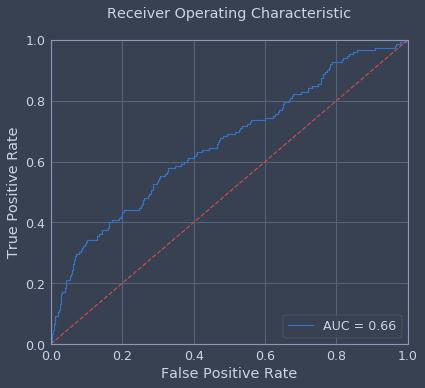

In [80]:
plot_roc_curve(log_model, X_test, y_test)

In [81]:
# Pass coefficents and feature names to see most important features
def feat_importance(coef, names, n=10):
    imp = coef
    imp,names = zip(*sorted(zip(imp[0],names)))
    fig = plt.figure(num=None, figsize=(8, 6), dpi=80)
    plt.barh(range(len(names[-n:])), imp[-n:], align='center')
    plt.yticks(range(len(names[-n:])), names[-n:])
    plt.title("Most Important Features \n")
    plt.xlabel("coefficient")
    plt.ylabel("features")
    plt.show()

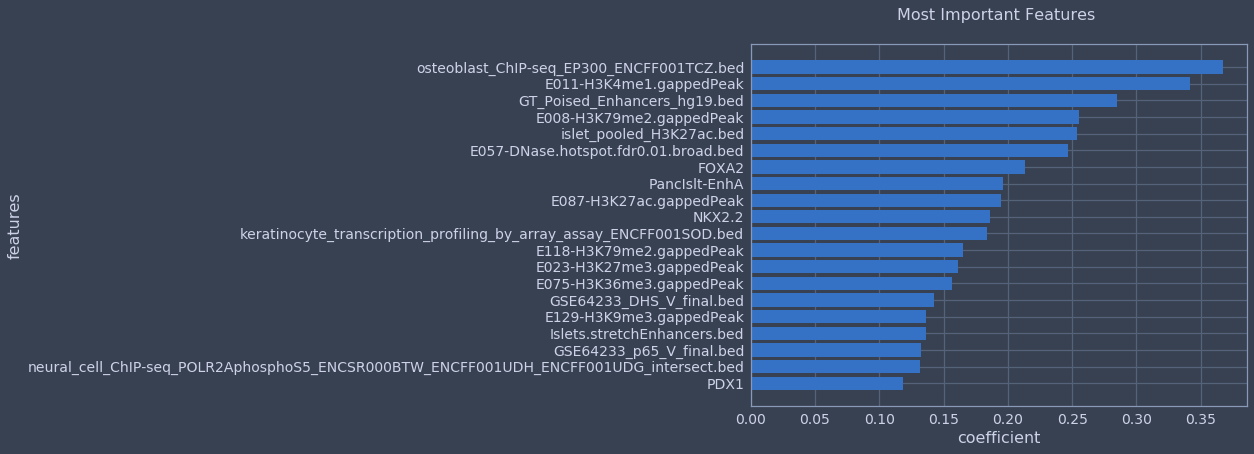

In [82]:
# Plot feature importance
coefs = log_model.coef_
feature_names = X_train.columns
feat_importance(coefs, feature_names, 20)

# Random Forest

In [83]:
# n_jobs = -1 allows training to be done on all available cores
rf_model = RandomForestClassifier(n_jobs=-1, class_weight='balanced')

# Parameter grid for grid search
rf_params = {'n_estimators': [100, 500, 1000, 2000],
			 'max_depth': [30, 100, 200]}

scoring = ['recall', 'roc_auc']

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.3)

In [84]:
# Grid search to iteratively search parameter space
rf_grid = GridSearchCV(rf_model, param_grid=rf_params, cv=cv, scoring=scoring, refit='recall')
rf_grid.fit(X_train, y_train, sample_weight=sample_weight)
print("The best parameters are %s with a score of %0.2f" % (rf_grid.best_params_, rf_grid.best_score_))

rf_grid_score = rf_grid.score(X_test, y_test)
print ("Grid search's score on new test data was {}".format(rf_grid_score))

The best parameters are {'max_depth': 30, 'n_estimators': 100} with a score of 0.00
Grid search's score on new test data was 0.0


In [85]:
summarize_performance(rf_grid, X_train, y_train, proba=False)

Model Performance:
 Precision: 1.0
 Recall: 1.0
 Accuracy: 1.0


In [86]:
summarize_performance(rf_grid.best_estimator_, X_test, y_test, proba=False)

Model Performance:
 Precision: 0.0
 Recall: 0.0
 Accuracy: 0.8571428571428571


In [87]:
# Eye test to see if we predict only one class
print (rf_grid.predict(X_test))

[0 0 0 ... 0 0 0]


In [88]:
top_n_features = 20

forest = rf_grid.best_estimator_
importances = rf_grid.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(top_n_features):
    print("%d. feature %s (%f)" % (f + 1, X_train.columns[f], importances[indices[f]]))

Feature ranking:
1. feature MCF-7_ChIP-seq_CTCF_ENCSR000AHD_ENCFF001UML_ENCFF001UMN_intersect.bed (0.005676)
2. feature MCF-7_ChIP-seq_TAF1_ENCSR000AHF_ENCFF001UNU_ENCFF001UNT_intersect.bed (0.003405)
3. feature GM12878_ChIP-seq_CTCF_ENCFF002CDP.bed (0.002813)
4. feature K562_ChIP-seq_CTCF_ENCFF002CEL.bed (0.002541)
5. feature K562_ChIP-seq_POLR2A_ENCFF002CET.bed (0.002490)
6. feature endothelial_cell_of_umbilical_vein_ChIP-seq_CTCF_ENCFF002CEH.bed (0.002357)
7. feature endothelial_cell_of_umbilical_vein_ChIP-seq_POLR2A_ENCFF002CEJ.bed (0.002169)
8. feature keratinocyte_ChIP-seq_CTCF_ENCFF002CFA.bed (0.002163)
9. feature keratinocyte_ChIP-seq_POLR2A_ENCFF002CFC.bed (0.002092)
10. feature H1-hESC_ChIP-seq_H3K27me3_ENCFF001SUY.bed (0.001964)
11. feature mammary_epithelial_cell_ChIP-seq_CTCF_ENCFF002CEB.bed (0.001944)
12. feature HepG2_ChIP-seq_CTCF_ENCFF002CDZ.bed (0.001898)
13. feature H1-hESC_ChIP-seq_CTCF_ENCFF002CDS.bed (0.001884)
14. feature H1-hESC_ChIP-seq_H3K4me3_ENCFF001SVC.bed 

### Support Vector Machine 

When used with a linear kernel still allows for evaluation of feature coefficients. Class weight parameter sets regularization parameter C for class i to n_samples / (n_classes * np.bincount(y)) 

In [89]:
svm_model = SVC(kernel='linear', class_weight='balanced', probability=True, max_iter=5000)
svm_model.fit(X_train, y_train, sample_weight=sample_weight)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=5000, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [90]:
print("Training Dataset SVM", end=" ")
summarize_performance(svm_model, X_train, y_train, proba=False)

Training Dataset SVM Model Performance:
 Precision: 0.8757225433526011
 Recall: 1.0
 Accuracy: 0.9797265440829798


In [91]:
print("Training Dataset SVM", end=" ")
summarize_performance(svm_model, X_test, y_test, proba=False)

Training Dataset SVM Model Performance:
 Precision: 0.22435897435897437
 Recall: 0.23026315789473684
 Accuracy: 0.7763157894736842


In [92]:
# Display samples that have been chosen as support vectors
svec_indices = svm_model.support_
svec_df = X_train.iloc[[124, 60, 112, 184, 53], :]
svec_df.tail()

,MCF-7_ChIP-seq_CTCF_ENCSR000AHD_ENCFF001UML_ENCFF001UMN_intersect.bed,MCF-7_ChIP-seq_TAF1_ENCSR000AHF_ENCFF001UNU_ENCFF001UNT_intersect.bed,GM12878_ChIP-seq_CTCF_ENCFF002CDP.bed,K562_ChIP-seq_CTCF_ENCFF002CEL.bed,K562_ChIP-seq_POLR2A_ENCFF002CET.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_CTCF_ENCFF002CEH.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_POLR2A_ENCFF002CEJ.bed,keratinocyte_ChIP-seq_CTCF_ENCFF002CFA.bed,keratinocyte_ChIP-seq_POLR2A_ENCFF002CFC.bed,H1-hESC_ChIP-seq_H3K27me3_ENCFF001SUY.bed,...,Hepatocyte_PPARA_GW7647_2hr.bed,Hepatocyte_PPARA_GW7647_24hr.bed,liver_USF1_ctrl_peaks.narrowPeak,liver_USF1_ASH_peaks.narrowPeak,islet_pooled_H3K4me1_final.bed,islet_CTCF_intersectall.bed,islet_H3K27ac.bed,islet_pooled_H3K27ac.bed,islet_pooled_H3K4me3_peaks.broadPeak,snpcount
21,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2
1107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16
1471,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,109
1661,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [93]:
svec_labels = y_train.iloc[svec_indices]
svec_labels[svec_labels.iloc[:] == 1].head()

53     1
284    1
175    1
116    1
117    1
Name: type, dtype: int64

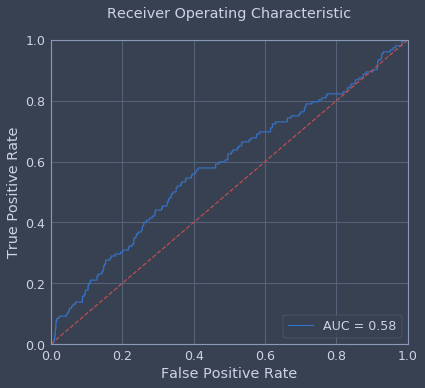

In [94]:
plot_roc_curve(svm_model, X_test, y_test)

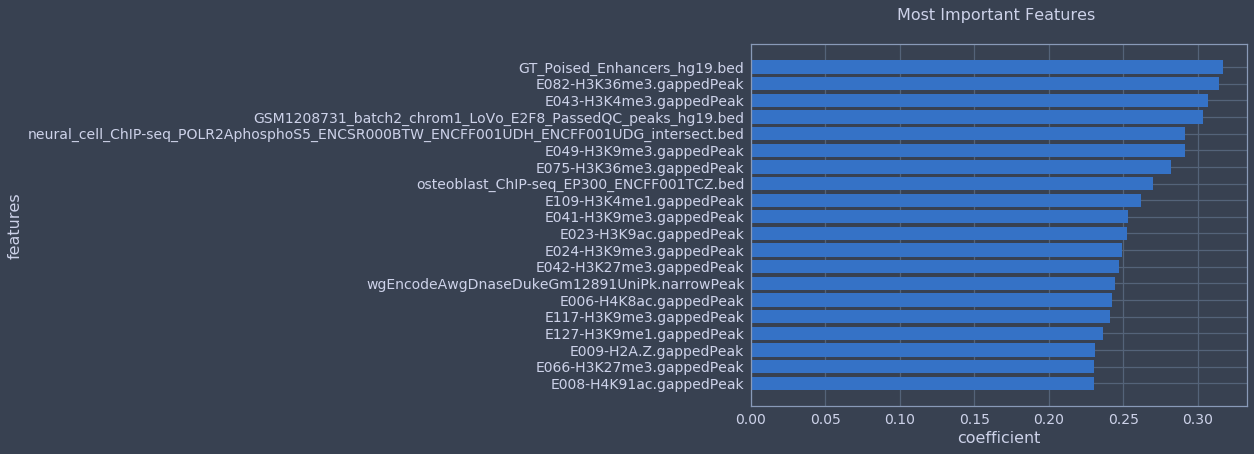

In [95]:
# Plot feature importance
coefs = svm_model.coef_
feature_names = X_train.columns
feat_importance(coefs, feature_names, 20)

### Complement Naive Bayes

Designed to combat the assumptions made by the standard multinomial naive bayes classifier. Particularly suited for imbalanced datasets as the priors are calculated by using the complement of the class of each sample. 

In [96]:
cnb_model = ComplementNB()
cnb_model.fit(X_train, y_train, sample_weight=None)

ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)

In [97]:
print("Training Dataset CNB", end=" ")
summarize_performance(cnb_model, X_train, y_train, proba=False)

Training Dataset CNB Model Performance:
 Precision: 0.24305555555555555
 Recall: 0.3465346534653465
 Accuracy: 0.7524752475247525


In [98]:
print("Training Dataset CNB", end=" ")
summarize_performance(cnb_model, X_test, y_test, proba=False)

Training Dataset CNB Model Performance:
 Precision: 0.2300469483568075
 Recall: 0.3223684210526316
 Accuracy: 0.7490601503759399


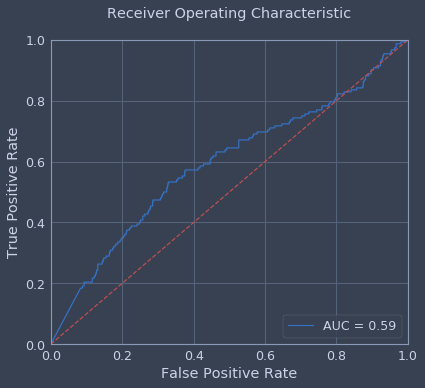

In [99]:
plot_roc_curve(cnb_model, X_test, y_test)